In [6]:
!pip install -U SimpleITK

In [3]:
!python.exe -m pip install --upgrade pip

In [5]:
!python3 -m pip install simpleitk

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nibabel as nib
import os
import h5py
import SimpleITK
import time
import random

import cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ReLU, AveragePooling3D, UpSampling3D, Concatenate, Softmax

from skimage.transform import resize
from contextlib import contextmanager
from functools import partial
from tqdm.notebook import tqdm

In [56]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [2]:
path = "D:\lv segment\CAMUS_public\database_nifti"

patient_folder_names = os.listdir(path)
patien_folder_names_length = len(patient_folder_names)

train_size = int(patien_folder_names_length * 0.8)
test_size = patien_folder_names_length - train_size

train_size, test_size

(160, 40)

In [3]:
random.seed(42)

train_names = random.choices(patient_folder_names, k = train_size)
test_names = random.choices(patient_folder_names, k = test_size)

train_names[:10],"---------------" ,test_names[:10]

(['patient0128',
  'patient0006',
  'patient0056',
  'patient0045',
  'patient0148',
  'patient0136',
  'patient0179',
  'patient0018',
  'patient0085',
  'patient0006'],
 '---------------',
 ['patient0015',
  'patient0127',
  'patient0046',
  'patient0182',
  'patient0172',
  'patient0015',
  'patient0048',
  'patient0134',
  'patient0043',
  'patient0027'])

In [3]:
mask_files_path = []
image_files_path = []

for i in patient_folder_names: 

    folder_path = os.listdir(os.path.join(path, i))
    

    mask_file_path = filter(lambda x: x.endswith("_gt.nii.gz"), folder_path)
    
    
    mask_files_path.extend([os.path.join(path, i, mf) for mf in mask_file_path])
    
for i in patient_folder_names: 

    folder_path = os.listdir(os.path.join(path, i))
    
    
    image_file_path = filter(lambda x: x.endswith(".nii.gz") and x not in mask_files_path, folder_path)
    
    
    image_files_path.extend([os.path.join(path, i, img) for img in image_file_path])

for i in range(len(image_files_path)):
    print(image_files_path[i], "   |   ", mask_files_path[i])

D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_ED.nii.gz    |    D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_ED_gt.nii.gz
D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_ED_gt.nii.gz    |    D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_ES_gt.nii.gz
D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_ES.nii.gz    |    D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_half_sequence_gt.nii.gz
D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_ES_gt.nii.gz    |    D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_4CH_ED_gt.nii.gz
D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_half_sequence.nii.gz    |    D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_4CH_ES_gt.nii.gz
D:\lv segment\CAMUS_public\database_nifti\patient0001\patient0001_2CH_half_sequence_gt.nii.gz    |    D:\lv segment\C

IndexError: list index out of range

In [4]:
def data_norm(input):
    
    input = np.array(input, dtype=np.float32)
    input  = input - np.mean(input)
    output = input / (np.std(input) + 1e-12)
    return output

def plot_histogram(image, title):
    
    plt.figure()
    plt.hist(image.ravel(), bins=256)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


def nii_to_array(path) : 
    
    img = nib.load(path)
    img_data = img.get_fdata()

    return img_data, img_data.shape

def get_scale(path) : 

    return nii_to_array(path)[1].shape[0], nii_to_array(path)[1].shape[1] # -> width, length

def resize_image(image, width, height):
    
    return resize(image, (height, width), preserve_range=True, mode='reflect', anti_aliasing=True)

In [21]:
def preprocess_images_and_masks(image_files, mask_files, width, height, depth=32):
    
    preprocessed_images = []
    preprocessed_masks = []

    for img_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files)):
        img = nii_to_array(img_file)[0]  
        mask = nii_to_array(mask_file)[0]  

        
        img_resized = np.zeros((depth, height, width), dtype=np.float32)
        mask_resized = np.zeros((depth, height, width), dtype=np.float32)

        for i in range(depth):  
            img_resized[i] = resize_image(img[i], width, height)
            mask_resized[i] = resize_image(mask[i], width, height)

        img_normalized = data_norm(img_resized)  

        preprocessed_images.append(img_normalized)
        preprocessed_masks.append(mask_resized)

    
    return preprocessed_images, preprocessed_masks


In [46]:
RESIZED_WIDTH = 256
RESIZED_LENGTH = 256
BATCH_SIZE = 8

for batch_start in range(0, 50, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(image_files_path))

    X_batch, y_batch = preprocess_images_and_masks(
        image_files_path[batch_start:batch_end],   
        mask_files_path[batch_start:batch_end],    
        RESIZED_WIDTH, RESIZED_LENGTH           
    )

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [47]:
preprocessed_data_path = r"D:\lv segment\preprocessed data"

if not os.path.exists(preprocessed_data_path):
    os.makedirs(preprocessed_data_path)

np.savez(
    os.path.join(preprocessed_data_path, f"preprocessed_data_batch_{batch_start}_{batch_end}.npz"),
    X=X_batch, y=y_batch
)


Original image shape: (549, 389)


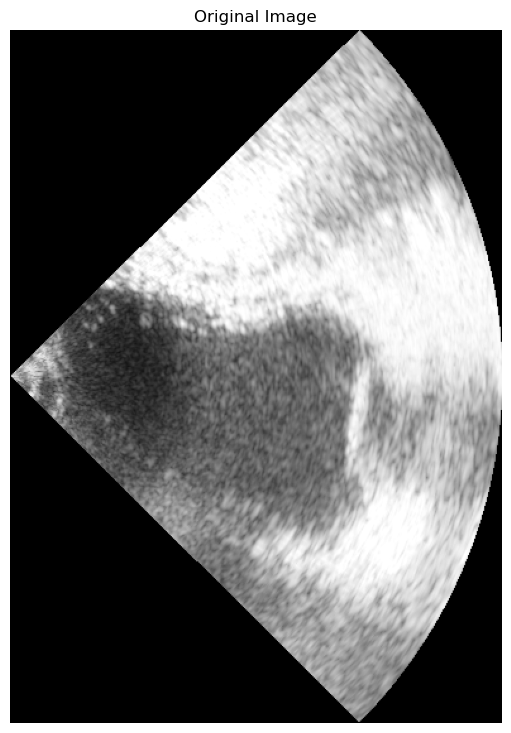

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def display_original(image_files_path, index, image_index):
    img_path = image_files_path[index]
    original_image = nii_to_array(img_path)[0]

    print("Original image shape:", original_image.shape)

    fig, ax = plt.subplots()
    ax.imshow(original_image, cmap='gray')
    ax.set_title('Original Image')
    ax.axis('off')

#def display_preprocessed() :

display_original(image_files_path, index, image_index)


In [16]:


def build_prior_net(input_shape=(224, 224, 8, 1)) :
    
    inputs = Input(input_shape)

    x = Conv3D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv3D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv3D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = AveragePooling3D(pool_size=(2, 2, 2))(x)
    
    x = Conv3D(192, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    latent_space = Conv3D(12, kernel_size=3, padding='same')(x)  

    return tf.keras.Model(inputs, latent_space, name="Prior-Net")


def build_i2i_net(input_shape=(128, 128, 128, 1)):
    inputs = Input(input_shape)

    
    x = Conv3D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv3D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = AveragePooling3D(pool_size=(2, 2, 2))(x)
    
    x = Conv3D(192, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    latent_space = Conv3D(12, kernel_size=3, padding='same')(x)

    
    x = Conv3D(128, kernel_size=3, padding='same')(latent_space)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = UpSampling3D(size=(2, 2, 2))(x)
    
    x = Conv3D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    
    x = Concatenate()([x, inputs])

    x = Conv3D(32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    outputs = Conv3D(6, kernel_size=1, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs, name="I2I-Net")



prior_net = build_prior_net()
i2i_net = build_i2i_net()


prior_net.summary()
i2i_net.summary()

Model: "Prior-Net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 8, 1)   0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 224, 224, 8, 64)   1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 8, 64)   256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 224, 224, 8, 64)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 224, 224, 8, 64)   110656    
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 8, 64)   25